In [60]:
# pip install numpy
# pip install matplotlib
# pip install scipy
# pip install scikit-image
# pip install opencv-python
# pip install pandas
# pip install tqdm
# pip install albumentations
# pip install torch
# pip install torchvision

In [1]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
import cv2
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
%matplotlib inline

In [2]:
# target_csv = 'deeplabv3+_se_resnext101_32x4d_Vanilla_final_2.csv'
target_csv = 'submission_all.csv'

In [3]:
# 1 x 65536 -> 256 x 256
def decode(rle_mask):
    mask = rle_mask.split()
    img = np.zeros(256*256, dtype=np.uint8)
    for i, m, in enumerate(mask):
        img[i] = int(m)
    return img.reshape(256,256)

In [4]:
df = pd.read_csv(target_csv)
df.head()

,image_id,PredictionString
0,batch_01_vt/0021.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,batch_01_vt/0028.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,batch_01_vt/0031.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,batch_01_vt/0032.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,batch_01_vt/0076.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


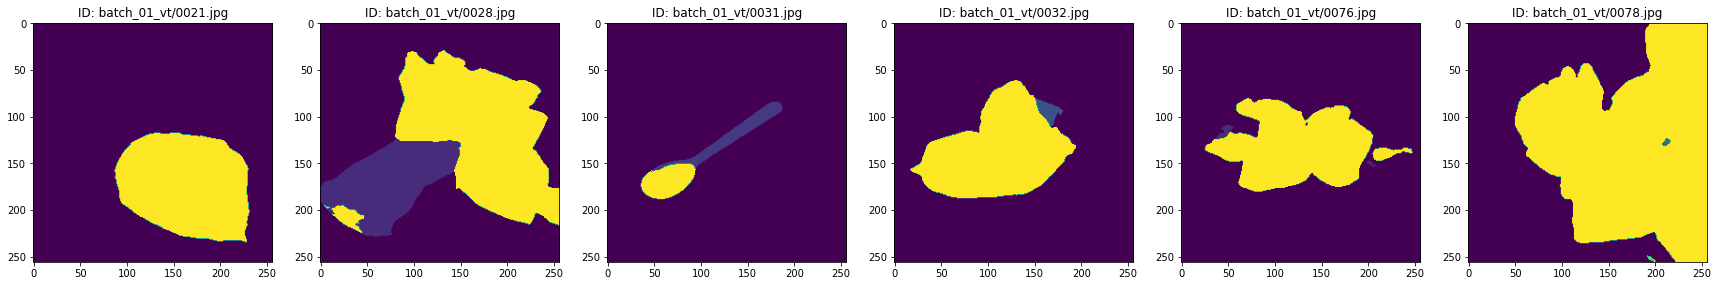

In [5]:
"""
reading and decoding the submission 

"""

i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..

# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'image_id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [6]:
"""
Function which returns the labelled image after applying CRF

"""
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img, resized=True):
    # print(original_image)
    if resized:
        original_image = cv2.resize(original_image, (256, 256))
    # print(original_image)
    
    labels = mask_img.flatten()

    # print(len(labels))
    n_labels = 11
    
    #Setting up the CRF model
    
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3,3), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(10,10), srgb=(70,70,70), rgbim=original_image, compat=3)

    Q = d.inference(45) #45

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [7]:
test_path = '../input/data/'

In [9]:
transform = A.Compose([
    # A.CLAHE(always_apply=False, p=1.0, clip_limit=(1, 1), tile_grid_size=(100, 100))
        # A.ToGray(always_apply=False, p=1.0),
    # A.Equalize(always_apply=False, p=1.0, mode='cv', by_channels=True),
      A.Resize(256,256)
    # A.ToSepia(always_apply=False, p=1.0),
    # A.Solarize(always_apply=False, p=1.0, threshold=(128, 128)),
    # A.ChannelShuffle(always_apply=False, p=1.0),
    # A.InvertImg(always_apply=False, p=1.0),
    # A.Downscale(always_apply=False, p=1.0, scale_min=0.25, scale_max=0.25, interpolation=0)
                           ])


In [93]:
4,44
33 종이


SyntaxError: invalid syntax (<ipython-input-93-625b39209a99>, line 2)

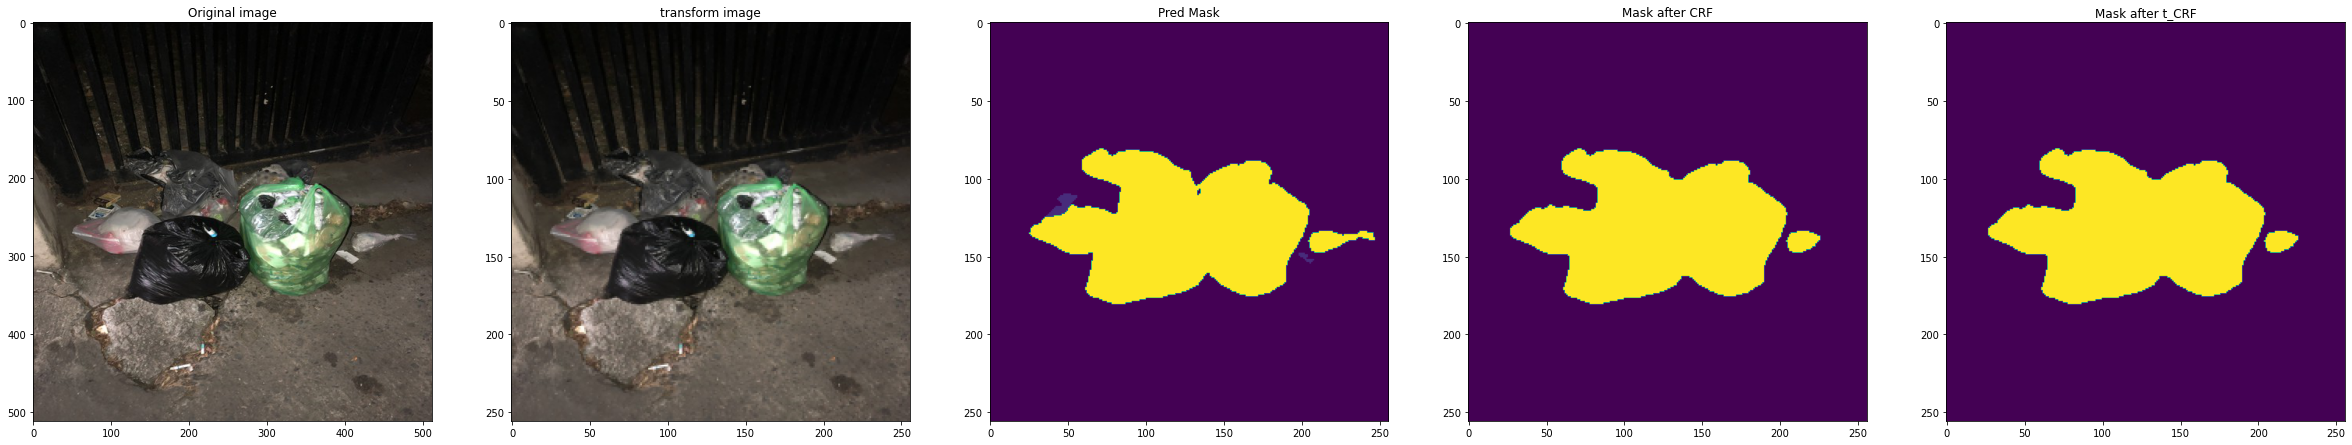

In [18]:
"""
visualizing the effect of applying CRF

"""
nImgs = 1
i = 4
j = 1
plt.figure(figsize=(50,150))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString']) # 1 x 65536 -> 256 x 256       
        orig_img = imread(test_path+df.loc[i,'image_id']) # 512 x 512 x 3
        #Applying CRF on FCN-16 annotated image
        t_image = transform(image=orig_img)['image']
        crf_output = crf(orig_img,decoded_mask)
        decoded_mask = transform(image=decoded_mask)['image']
        t_crf_output = crf(t_image,decoded_mask,resized=False)
        plt.subplot(nImgs,6,6*j-5)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,6,6*j-4)
        plt.imshow(t_image)
        plt.title('transform image')
        plt.subplot(nImgs,6,6*j-3)
        plt.imshow(decoded_mask) 
        plt.title('Pred Mask')
        plt.subplot(nImgs,6,6*j-2)
        plt.imshow(crf_output) 
        plt.title('Mask after CRF')
        plt.subplot(nImgs,6,6*j-1)
        plt.imshow(t_crf_output) 
        plt.title('Mask after t_CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    # print(j)
    i = i + 1

In [8]:
"""
visualizing the effect of applying CRF

"""
nImgs = 1
i = 33
j = 1
plt.figure(figsize=(50,150))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString']) # 1 x 65536 -> 256 x 256       
        orig_img = imread(test_path+df.loc[i,'image_id']) # 512 x 512 x 3
        #Applying CRF on FCN-16 annotated image
        t_image = transform(image=orig_img)['image']
        crf_output = crf(orig_img,decoded_mask)
        decoded_mask = transform(image=decoded_mask)['image']
        t_crf_output = crf(t_image,decoded_mask,resized=False)
        plt.subplot(nImgs,6,6*j-5)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,6,6*j-4)
        plt.imshow(t_image)
        plt.title('transform image')
        plt.subplot(nImgs,6,6*j-3)
        plt.imshow(decoded_mask) 
        plt.title('Pred Mask')
        plt.subplot(nImgs,6,6*j-2)
        plt.imshow(crf_output) 
        plt.title('Mask after CRF')
        plt.subplot(nImgs,6,6*j-1)
        plt.imshow(t_crf_output) 
        plt.title('Mask after t_CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    # print(j)
    i = i + 1

NameError: name 'transform' is not defined

<Figure size 3600x10800 with 0 Axes>

In [49]:
"""
used for converting the decoded image to rle mask

"""
def encode(im):
    pixels = im.flatten()
    return ' '.join(str(x) for x in pixels)

In [50]:
"""
Applying CRF on the predicted mask 

# """
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])        
        orig_img = imread(test_path+df.loc[i,'image_id'])        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'PredictionString'] = encode(crf_output)

100%|██████████| 819/819 [13:21<00:00,  1.02it/s]


In [51]:
df.to_csv('./submission/crf_' + target_csv+'2', index=False)